[1 2 2]
5 [1 3 5]
[16, 32, 64] [16, 32, 64] 3 3
10000 (10000L, 3L, 32L, 32L)


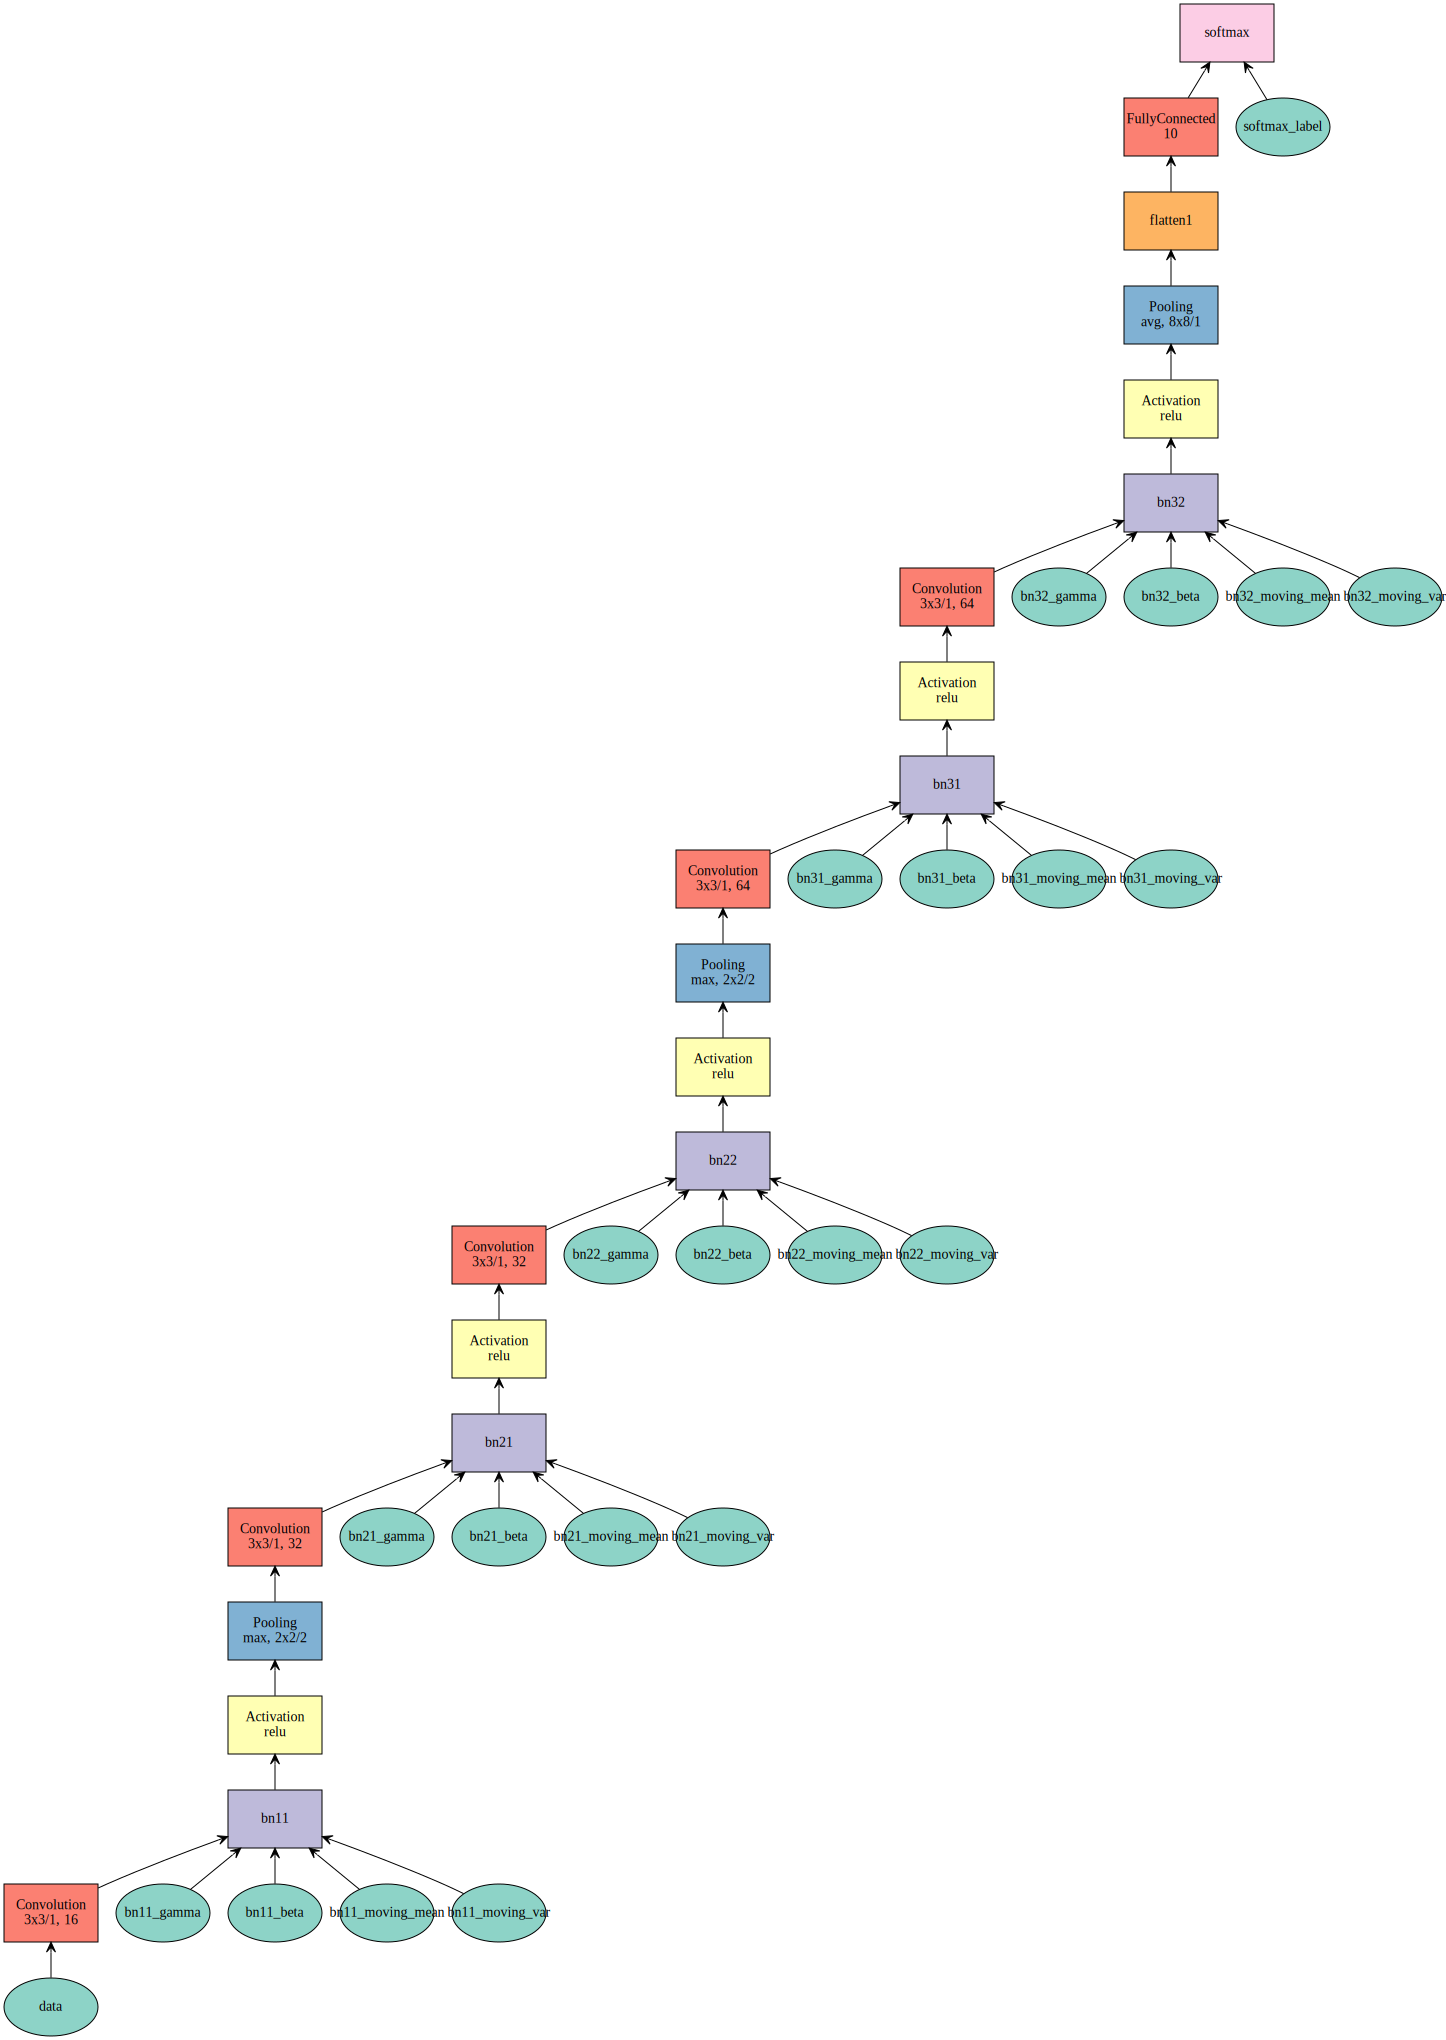

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-16 14:41:48.063585. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
#greedy pca net
############################ set hyperparameters ###############################
import find_mxnet
assert find_mxnet
import mxnet as mx
import argparse
import os
import logging
import numpy as np
import matplotlib.pyplot as plt

ks = 3
pks = 3
hks = (ks-1)/2
hpks = (pks-1)/2
num_filters1=[8,40,128]
#num_filters1=[16,16,16,16]
num_filters2=[16,32,64]
num_filters1=num_filters2
layer = 2
num_layers = np.array([1,layer,layer])
print num_layers
num_levels = num_layers.size
num_conv = num_layers.sum()
end_layers = np.zeros(num_levels,dtype=int)
for i in range(num_levels):
    end_layers[i] = np.sum(num_layers[0:i+1])

print num_conv, end_layers
    
lr_mult  = 1.0
log_file = 'greedy_pca'
log_dir = 'cifar10'

batch_size = 100
magnitude = 1e-2
num_epoch = 50
learning_rate = 1e-1
momentum = 0.9
eps = 1e-4
load_epoch = None
num_gpu = 2
devs = [mx.gpu(int(i)) for i in range(num_gpu)]
kv_store = 'local'
num_examples = 50000
num_train = 50000
data_dir = 'cifar/'
chk_dir = 'model/'
chk_prefix = chk_dir + log_file
r = None

epoch_size = num_examples / batch_size
factor = 0.95

################################  path #########################################

# download data if necessary
def _download(data_dir):
    if not os.path.isdir(data_dir):
        os.system("mkdir " + data_dir)
    os.chdir(data_dir)
    if (not os.path.exists('train.rec')) or \
       (not os.path.exists('test.rec')) :
        os.system("wget http://data.dmlc.ml/mxnet/data/cifar10.zip")
        os.system("unzip -u cifar10.zip")
        os.system("mv cifar/* .; rm -rf cifar; rm cifar10.zip")
    os.chdir("..")
    


def log_to_list(period,lst):
    def _callback(param):
        if (param.nbatch+1) % period == 0 and param.eval_metric is not None:
            name_value = param.eval_metric.get_name_value()
            for name, value in name_value:
                lst.append(value)
    return _callback

# data
def get_iterator(data_dir, batch_size):
    kargs = dict(
        data_shape=(3, 32, 32),
    )
    if '://' not in data_dir:
        _download(data_dir)     
        
        
    train = mx.io.ImageRecordIter(
        path_imgrec=data_dir + 'train.rec',
        batch_size=batch_size,
        rand_crop=True,
        rand_mirror=True,
        pad=4,
        fill_value=127,
        shuffle=True,
        **kargs
    )
    val = mx.io.ImageRecordIter(
        path_imgrec=data_dir + 'test.rec',
        rand_crop=False,
        rand_mirror=False,
        batch_size=batch_size,
        **kargs
    )
    return (train,val)

def PCA(data, r = 0.95, k = None):
    """
    returns: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """
    from scipy import linalg as la
    m, n = data.shape
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    #R = np.cov(data, rowvar=False)
    R = np.dot(data,data.T)/float(n)
    evals, evecs = la.eigh(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]

    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors
    sum_evals = np.sum(evals)
    if r is not None and k is None:
        for i in range(m):
            ratio = np.sum(evals[0:i])/sum_evals
            if ratio>=r:
                k = i
                break
    elif k is not None:
        ratio = np.sum(evals[0:k])/sum_evals
    
    # select the first k eigenvectors 
    evecs = evecs[:, :k]           
    print 'The ratio of the first %d eigenvalues is %f'%(k,ratio)
    return evals, evecs  

def get_block(data,level,layer,num_filter1,num_filter2,ks,hks,pks,hpks,momentum=0.9):
    data = mx.sym.Convolution(data=data,name="pca"+str(level)+str(layer), kernel=(pks,pks), pad=(hpks,hpks), num_filter=num_filter1)
    #data = mx.sym.Convolution(data=data,name="alpha"+str(level)+str(layer), kernel=(1,1), pad=(0,0), num_filter=num_filter2)
    data = mx.symbol.BatchNorm(data=data, name="bn"+str(level)+str(layer), fix_gamma=False, momentum=momentum, eps=2e-5)
    data = mx.symbol.Activation(data=data, act_type="relu", name="relu"+str(level)+str(layer))
        
    return data
print num_filters1,num_filters2, ks, pks

def get_net(num_classes=10,num_filters1=num_filters1,num_filters2=num_filters2,num_levels=num_levels,num_layers=num_layers,ks=ks, pks=pks, pool_kernel = (2,2), lr_mult=0.0):
    hks = int((ks-1)/2)
    hpks = int((pks-1)/2)
    data = mx.symbol.Variable(name="data")
    for l in range(num_levels):
        num_filter1 = num_filters1[l]
        num_filter2 = num_filters2[l]
        layers = num_layers[l]   
        for layer in range(layers):
            data = get_block(data=data,level=l+1,layer=layer+1,num_filter1=num_filter1,num_filter2=num_filter2,ks=ks,hks=hks,pks=pks,hpks=hpks)
        if l<num_levels-1:
            data = mx.sym.Pooling(data=data, name="pool"+str(l+1), pool_type="max", kernel=(2, 2),stride=(2, 2))
    
    pool = mx.symbol.Pooling(data=data, kernel=pool_kernel, pool_type='avg')
    flat = mx.symbol.Flatten(data=pool)
    fc = mx.symbol.FullyConnected(data=flat, num_hidden=num_classes, name='fc')
    softmax = mx.sym.SoftmaxOutput(data=fc, name='softmax')
    return softmax

def get_im2col_indices(x_shape, field_height, field_width, padding=1, stride=1):
  # First figure out what the size of the output should be
  N, C, H, W = x_shape
  assert (H + 2 * padding - field_height) % stride == 0
  assert (W + 2 * padding - field_height) % stride == 0
  out_height = (H + 2 * padding - field_height) / stride + 1
  out_width = (W + 2 * padding - field_width) / stride + 1

  i0 = np.repeat(np.arange(field_height), field_width)
  i0 = np.tile(i0, C)
  i1 = stride * np.repeat(np.arange(out_height), out_width)
  j0 = np.tile(np.arange(field_width), field_height * C)
  j1 = stride * np.tile(np.arange(out_width), out_height)
  i = i0.reshape(-1, 1) + i1.reshape(1, -1)
  j = j0.reshape(-1, 1) + j1.reshape(1, -1)

  k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

  return (k, i, j)


def im2col_indices(x, field_height, field_width, padding=1, stride=1):
  """ An implementation of im2col based on some fancy indexing """
  # Zero-pad the input
  p = padding
  x_padded = np.pad(x, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant')

  k, i, j = get_im2col_indices(x.shape, field_height, field_width, padding, stride)

  cols = x_padded[:, k, i, j]
  C = x.shape[1]
  cols = cols.transpose(1, 2, 0).reshape(field_height * field_width * C, -1)
  return cols


def get_patches(data,patch_size = (3,3)):
    # data: numpy array of shape N,C,H,W
    data_type = type(data)
    if data_type ==  type(mx.nd.array([1])):
        data = data.asnumpy()

    N,C,H,W = data.shape
    cols = im2col_indices(data, patch_size[0], patch_size[1], 0, 1)
    return cols

def layer_forward(ctx,f_in,args_all,aux_all,level,layer,num_filter1,num_filter2,ks,hks,pks,hpks,momentum=0.9,pooling=False):
    f = mx.symbol.Variable(name="data")
    f = get_block(f,level+1,layer+1,num_filter1,num_filter2,ks,hks,pks,hpks,momentum)
    if pooling:
        f = mx.sym.Pooling(data=f, name="pool"+str(level+1), pool_type="max", kernel=(2, 2),stride=(2, 2))
    executor =f.simple_bind(ctx=ctx, data=f_in.shape, grad_req='null')
    args = executor.arg_dict
    aux = executor.aux_dict
    for key in args:
        if key != 'data':
            args[key][:] = args_all[key]
    args['data'][:] = f_in

    for key in aux:
        aux[key][:] = aux_all[key]

    executor.forward(is_train=False)
    f_out = executor.outputs[0]
    print 'f_out:', f_out
    #print 'layer forward name:', name
    return f_out

def mod_layer_forward(ctx,f_in,args_all,aux_all,level,layer,num_filter1,num_filter2,ks,hks,pks,hpks,momentum=0.9,pooling=False):
    f = mx.symbol.Variable(name="data")
    f = get_block(f,level+1,layer+1,num_filter1,num_filter2,ks,hks,pks,hpks,momentum)
    if pooling:
        f = mx.sym.Pooling(data=f, name="pool"+str(level+1), pool_type="max", kernel=(2, 2),stride=(2, 2))

    return f

def get_pcalayer(X,level,layer,num_filters):
    cols = get_patches(X,(pks,pks))
    nk = num_filters[level]
    evals, evecs = PCA(cols, r, nk)
    weights = np.zeros((nk,X.shape[1],pks,pks))
    for n in range(nk):
        weights[n,:,:,:]= np.reshape(evecs[:,n],(X.shape[1],pks,pks))
    return mx.nd.array(weights)

def get_pcadata_net(clevel=0,clayer=0, ks = ks, pks = pks,num_filters1=num_filters1,num_filters2=num_filters2):
    hks = int((ks-1)/2)
    hpks = int((pks-1)/2)
    data = mx.symbol.Variable(name="data")
    for l in range(clevel+1):
        num_filter1 = num_filters1[l]
        num_filter2 = num_filters2[l]
        layers = num_layers[l]
        if l<clevel:
            for layer in range(layers):
                data = get_block(data=data,level=l+1,layer=layer+1,num_filter1=num_filter1,num_filter2=num_filter2,ks=ks,hks=hks,pks=pks,hpks=hpks)
            data = mx.sym.Pooling(data=data, name="pool"+str(l+1), pool_type="max", kernel=(2, 2),stride=(2, 2))
        else:
            if clayer > 0:
                for layer in range(clayer):
                    data = get_block(data=data,level=l+1,layer=layer+1,num_filter1=num_filter1,num_filter2=num_filter2,ks=ks,hks=hks,pks=pks,hpks=hpks)
            #out = mx.sym.Convolution(data=data,name="pca"+str(clevel+1)+str(clayer+1), kernel=(pks,pks), pad=(hpks,hpks), num_filter = num_filter1, no_bias=True)
    return data
    
def training_layer(num_classes=10, level=1, layer=1, num_filter1=16, bnmomentum = momentum,pool_kernel=(2,2)):
    data = mx.symbol.Variable(name="data")
    data = mx.symbol.Convolution(data=data,name="pca"+str(level)+str(layer), kernel=(pks,pks), pad=(hpks,hpks), num_filter=num_filter1)
    data = mx.symbol.BatchNorm(data=data,name="bn"+str(level)+str(layer), fix_gamma=False, momentum=bnmomentum, eps=2e-5)
    data = mx.symbol.Activation(data=data, act_type="relu", name="relu"+str(level)+str(layer))
    data = mx.symbol.Pooling(data=data, kernel=pool_kernel,stride = pool_kernel, pool_type='avg')
    #data = mx.symbol.Pooling(data=data,kernel=pool_kernel, global_pool = 'True', pool_type='avg')
    data = mx.symbol.Flatten(data=data)
    data = mx.symbol.FullyConnected(data=data, num_hidden=num_classes, name='fc')
    softmax = mx.symbol.SoftmaxOutput(data=data, name='softmax')    
    return softmax
                                 
     
        
acc = mx.metric.Accuracy()      
        
(train, val) = get_iterator(data_dir, batch_size)
        
train_pca = mx.io.ImageRecordIter(
        path_imgrec=data_dir + 'train.rec',
        batch_size=10000,
        rand_crop=False,
        rand_mirror=False,
        pad=4,
        fill_value=127,
        shuffle=False,
        data_shape=(3, 32, 32)
)
ctx = mx.gpu()
X_pca = mx.nd.zeros((num_train,3,32,32))
X_pca = mx.nd.zeros((10000,3,32,32))
i = 0

for batch in train_pca:
    batch_data = batch.data[0]
    length = batch_data.shape[0]
    if i+length <= X_pca.shape[0]:
        X_pca[i:length+i,:,:,:] = batch_data
        i = i+length
        print i, batch_data.shape
    else:
        break
    
plks =  32/(2**(num_levels-1))  
pool_kernel = (plks,plks)
#pca_kernels = get_pcalayer(X_pca,0,0,num_filters1)

random = 0



network = get_net(num_classes=10,num_filters1=num_filters1,num_filters2=num_filters2,num_levels=num_levels,num_layers=num_layers,ks=ks, pks=pks, pool_kernel = pool_kernel, lr_mult=0.0)

mod = mx.mod.Module(symbol=network, context=devs)
mod.bind(data_shapes=train.provide_data,label_shapes=train.provide_label, force_rebind=True)
mod.init_params(initializer=mx.init.Xavier(magnitude=0.01))
arg_params,aux_params =  mod.get_params()
mx.viz.plot_network(network)

#vis = mx.viz.plot_network(network, shape={"data":(64, 3, 32, 32)}, node_attrs={"shape":'rect',"fixedsize":'false'})
#vis.render('nonpcanet'+ str(num_conv))





In [3]:





wd = 0
FactorScheduler = mx.lr_scheduler.FactorScheduler(epoch_size,factor)
opt = mx.optimizer.SGD(learning_rate=learning_rate,
                       momentum=0.9,wd=wd,
                       lr_scheduler=FactorScheduler,
                       rescale_grad=1.0/batch_size)


we = arg_params['fc_weight'].copy()
metric = mx.metric.create('acc')

for clevel in range(num_levels):
    layers = num_layers[clevel]
    pooling = False
    num_filter1 = num_filters1[clevel]
    num_filter2 = num_filters2[clevel]
    
    num_filter2 = num_filters2[clevel]
    ratio = num_filters2[-1]/num_filter2
    #plks =  32/(2**(num_levels-clevel-1))  
    plks = 32/2**clevel
    pool_kernel = (plks,plks)
    
    for clayer in range(layers):
        print 'start training at level= %d, layer= %d' %(clevel,clayer)
        # get pca kernels
        # get mod for the pca trainning data 
        pcadata_net = get_pcadata_net(clevel=clevel,clayer = clayer)
        mod1 = None
        mod1 = mx.mod.Module(symbol=pcadata_net, context=devs)
        mod1.bind(data_shapes=train.provide_data,for_training=False,force_rebind=True) 
        mod1.init_params(initializer=mx.init.Xavier(magnitude=0.01))
        arg_params1,aux_params1 =  mod1.get_params()
        for key, weight in arg_params1.items():
            weight[:] = arg_params[key]
        for key, weight in aux_params1.items():
            weight[:] = aux_params[key]
        mod1.set_params(arg_params = arg_params1, aux_params=aux_params1) 
        name, output_shape = mod1.output_shapes[0]
        data_shape =  [mx.io.DataDesc(name = 'data', shape = output_shape,layout='NCHW')]
        # pool_kernel = ()
        # training
        training_net = training_layer(num_classes=10, level=clevel+1,layer=clayer+1, 
                                      num_filter1=num_filter1, bnmomentum = momentum,pool_kernel=pool_kernel)
        mod2 = None
        mod2 = mx.mod.Module(symbol=training_net, context=devs) 
        mod2.bind(data_shapes=data_shape, label_shapes=train.provide_label,force_rebind=True)
        mod2.init_params(initializer=mx.init.Xavier(magnitude=0.01))
        mod2.init_optimizer(optimizer=opt, force_init=False) 
        for epoch in range(num_epoch):
            train.reset()
            val.reset()
            for batch in train:
                mod1.forward(batch,is_train=False)
                outputs = mod1.get_outputs()
                databatch = mx.io.DataBatch(data=outputs, label=batch.label)     
                mod2.forward(databatch, is_train=True)       
                mod2.update_metric(metric, batch.label)  
                mod2.backward()                           
                mod2.update()
            _,tacc = metric.get()
            vacc = 0
            '''
            for batch in val:
                mod1.forward(batch,is_train=False)
                outputs = mod1.get_outputs()
                databatch = mx.io.DataBatch(data=outputs, label=batch.label)     
                mod2.forward(databatch, is_train=False)       
                mod2.update_metric(metric, batch.label)  
            _,vacc = metric.get() '''
            print 'epoch = %d, tacc = %f, vacc = %f' %(epoch, tacc, vacc)
        # get pca kernels
        arg_params2, aux_params2 = mod2.get_params()
        for key, weight in arg_params2.items():
            print key, arg_params[key].shape, weight.shape
            if 'fc' not in key:
                arg_params[key][:] = weight
        for key, weight in aux_params2.items():
            aux_params[key][:] = weight
        if  clayer==layers-1:
            pooling = True

        
            #print arg_layer['fc_weight'].asnumpy()

start training at level= 0, layer= 0
epoch = 0, tacc = 0.243280, vacc = 0.000000
epoch = 1, tacc = 0.274180, vacc = 0.000000
epoch = 2, tacc = 0.291033, vacc = 0.000000
epoch = 3, tacc = 0.303265, vacc = 0.000000
epoch = 4, tacc = 0.312540, vacc = 0.000000
epoch = 5, tacc = 0.319110, vacc = 0.000000
epoch = 6, tacc = 0.325374, vacc = 0.000000
epoch = 7, tacc = 0.330675, vacc = 0.000000
epoch = 8, tacc = 0.336133, vacc = 0.000000
epoch = 9, tacc = 0.340606, vacc = 0.000000
epoch = 10, tacc = 0.344873, vacc = 0.000000
epoch = 11, tacc = 0.348568, vacc = 0.000000
epoch = 12, tacc = 0.351989, vacc = 0.000000
epoch = 13, tacc = 0.354989, vacc = 0.000000
epoch = 14, tacc = 0.357875, vacc = 0.000000
epoch = 15, tacc = 0.360500, vacc = 0.000000
epoch = 16, tacc = 0.362976, vacc = 0.000000
epoch = 17, tacc = 0.365471, vacc = 0.000000
epoch = 18, tacc = 0.367861, vacc = 0.000000
epoch = 19, tacc = 0.370086, vacc = 0.000000
epoch = 20, tacc = 0.372227, vacc = 0.000000
epoch = 21, tacc = 0.374321,

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-16 14:42:27.668934. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
'''
print X_train.shape    
ind = 1
y = Y_train.asnumpy();
print y[ind]
img = X_train.asnumpy()[ind,:,:,:]
img = img.transpose(1,2,0)
img = np.flipud(img)
dpi = 20
figsize = (32/dpi,32/dpi)
fig = plt.figure(figsize=figsize)
imgplot = plt.imshow(np.reshape(np.uint8(img),(32,32,3)))
plt.axis('off')
plt.show()
ind = 1
x = val.getdata()
y = val.getlabel().asnumpy()
print y[ind]

img = x.asnumpy()[ind,:,:,:]
img = img.transpose(1,2,0)
img = np.flipud(img)
figsize = (32/dpi,32/dpi)
fig = plt.figure(figsize=figsize)
imgplot = plt.imshow(np.reshape(np.uint8(img),(32,32,3)))
plt.axis('off')
plt.show()
'''